In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
p =200

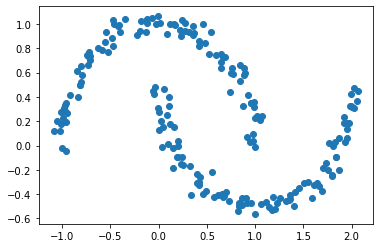

In [3]:
import sklearn

np.random.seed(9)

# mu = sklearn.datasets.make_blobs(n_samples=p, n_features=2, centers=3,shuffle=False)
mu = sklearn.datasets.make_moons(n_samples=p, noise=0.05,shuffle=False)

Y = mu[0]

plt.scatter(Y[:,0],Y[:,1])

In [4]:
import numba
from numba import jit

import importlib
import gibbs_sampling as gs

In [5]:
# importlib.reload(gs)

In [6]:
tree = gs.SpanningTree(Y)

In [7]:
# burn-in
# adjust step_size to have the acceptance rate close to 0.3

_ = tree.runMCMC(100, step_size = 0.02)

99
0.4


In [8]:
# collect Markov chain samples

trace = tree.runMCMC(1000, step_size = 0.02)

99
199
299
399
499
599
699
799
899
999
0.331


In [9]:
trace_A = [ gs.getA(trace[i][0]) for i in range(1000)]

In [10]:
trace_tau = np.array([ trace[i][3] for i in range(1000)])

In [11]:
mean_tau = np.mean(trace_tau)

In [12]:
# use the posterior mean of tau to quickly estimate the marginal connecting probability
tree.params[3] = mean_tau
prob = tree.computeMarginalProb()

In [13]:
degree = np.vstack([trace_A[i].sum(0) for i in range(1000)])

In [14]:
from statsmodels.tsa.stattools import acf
import arviz

In [15]:
acf_mat = np.vstack([ acf(degree[:,i], fft=False, nlags=40) for i in range(p)])

acf_mat[np.isnan(acf_mat)]=0

acf_mat[:,0]=1

ess = np.stack([arviz.ess(degree[:,i]) for i in range(p)])

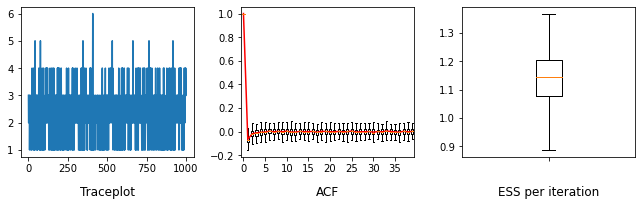

In [16]:
fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1, 1,1] })
fig.set_size_inches([9,3])

ax[0].plot(degree[:,2])
ax[0].set_title("Traceplot", y=-0.3)
# ax[0].plot(np.arange(2000),degreee[:,299]+1)

ax[1].boxplot(acf_mat[:,:40],  showfliers=False, )
ax[1].plot(np.arange(40)+1, acf_mat[:,:40].mean(0), color='red')
ax[1].set_xticks( np.arange(8)*5+1)
ax[1].set_xticklabels(np.arange(8)*5)
ax[1].set_title("ACF", y=-0.3)

ax[2].boxplot(ess/1000,  showfliers=False, )
ax[2].set_xticks( [1])
ax[2].set_xticklabels([""])
ax[2].set_title("ESS per iteration", y=-0.3)
fig.tight_layout(pad=1)
# fig.savefig("benchmark_gibbs.png")

In [17]:
A1 = gs.getA(trace[0][0])
A2 = gs.getA(trace[499][0])
A3 = gs.getA(trace[999][0])

In [18]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 8
# rcParams['figure.dpi'] = 300

In [19]:
import networkx as nx

In [20]:
width =2

In [21]:
from matplotlib import cm
cmap = cm.get_cmap('Reds', 10)


In [22]:
def pltGraph(A, color='r', usingWeight=True):
    M= nx.Graph(A)
    edges = M.edges()
    weights = [ np.log(prob[u][v]) for u,v in edges]
    
    if usingWeight:
        nx.draw(M,pos=Y,edge_color=weights,width=4, edge_cmap=cmap, node_size=100)
    else:
        nx.draw(M,pos=Y,edge_color=color,width=4, node_size=100)

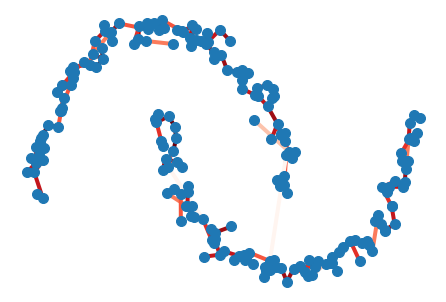

In [23]:
f = plt.figure()
pltGraph(A1)
# f.savefig("moons1.png")

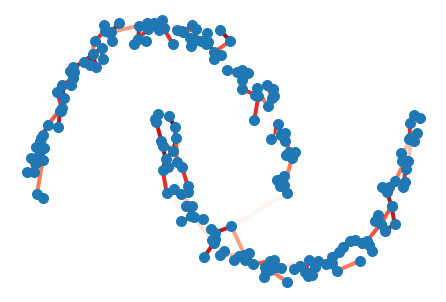

In [24]:
f = plt.figure()
pltGraph(A3,'red')
# f.savefig("moons2.png")

In [25]:
import seaborn as sns

In [26]:
cmap = cm.get_cmap('Blues', 20)

In [27]:
prob[prob<1E-3]=np.nan

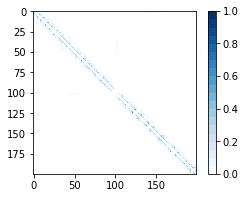

In [28]:
f = plt.figure(figsize=[4,3])

plt.imshow(prob, vmin=0.0,vmax=1,cmap=cmap)
plt.colorbar()

# f.savefig("moonsMarginal.png")